CODE BLOCK: 1

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchsummary import summary

CODE BLOCK: 2

In [2]:
# CUDA?
from utils import cuda,device

print("CUDA Available?", cuda)
device

CUDA Available? True


device(type='cuda')

CODE BLOCK: 3

In [3]:
# Train data transformations
from utils import train_transforms,test_transforms

CODE BLOCK: 4

In [4]:
train_data = datasets.MNIST('../../data', train=True, download=False, transform=train_transforms)
test_data = datasets.MNIST('../../data', train=False, download=False, transform=test_transforms)

CODE BLOCK: 5

In [5]:
batch_size = 128

if torch.cuda.is_available():
    kwargs = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 3, 'pin_memory': True}
else:
    kwargs = {'batch_size':32,'shuffle':True}

test_loader = torch.utils.data.DataLoader(test_data, **kwargs)
train_loader = torch.utils.data.DataLoader(train_data, **kwargs)

In [6]:
len(train_loader), len(test_loader),  len(train_data), len(test_data)

(469, 79, 60000, 10000)

In [7]:
len(train_data)/len(train_loader), len(test_data)/len(test_loader)

(127.9317697228145, 126.58227848101266)

CODE BLOCK: 6

C:\Users\muthu\AppData\Local\Temp\ipykernel_396\695351802.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


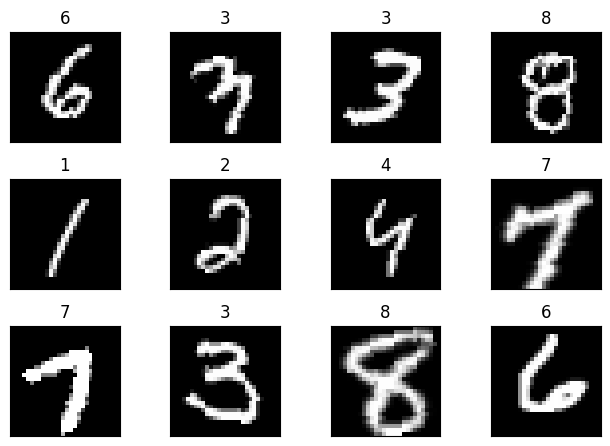

In [8]:
import matplotlib.pyplot as plt

batch_data, batch_label = next(iter(train_loader))

fig = plt.figure()

for i in range(12):
  plt.subplot(3,4,i+1)
  plt.tight_layout()
  plt.imshow(batch_data[i].squeeze(0), cmap='gray')
  plt.title(batch_label[i].item())
  plt.xticks([])
  plt.yticks([])
plt.show()

CODE BLOCK: 7

In [9]:
from model import Net

CODE BLOCK: 8

In [10]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

CODE BLOCK: 9

In [13]:

from tqdm import tqdm
from utils import GetCorrectPredCount


def train(model, device, train_loader, optimizer, criterion):
  model.train()
  pbar = tqdm(train_loader)

  train_loss = 0
  correct = 0
  processed = 0

  for batch_idx, (data, target) in enumerate(pbar):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()

    # Predict
    pred = model(data)

    # Calculate loss
    loss = criterion(pred, target)
    train_loss+=loss.item()

    # Backpropagation
    loss.backward()
    optimizer.step()

    correct += GetCorrectPredCount(pred, target)
    processed += len(data)

    pbar.set_description(desc= f'Train: Loss={loss.item():0.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

  train_acc.append(100*correct/processed)
  train_losses.append(train_loss/len(train_loader))

def test(model, device, test_loader, criterion):
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)

            output = model(data)
            test_loss += criterion(output, target, reduction='sum').item()  # sum up batch loss

            correct += GetCorrectPredCount(output, target)


    test_loss /= len(test_loader.dataset)
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


CODE BLOCK: 10

In [14]:
model = Net().to(device)
summary(model,(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
            Conv2d-2           [-1, 64, 24, 24]          18,496
            Conv2d-3          [-1, 128, 10, 10]          73,856
            Conv2d-4            [-1, 256, 8, 8]         295,168
            Linear-5                   [-1, 50]         204,850
            Linear-6                   [-1, 10]             510
Total params: 593,200
Trainable params: 593,200
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.67
Params size (MB): 2.26
Estimated Total Size (MB): 2.94
----------------------------------------------------------------


In [15]:
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1, verbose=True)
# New Line
criterion = F.cross_entropy
num_epochs = 20

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train(model, device, train_loader, optimizer, criterion)
  test(model, device, test_loader, criterion)
  scheduler.step()

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 1


Train: Loss=0.0931 Batch_id=468 Accuracy=85.45: 100%|██████████| 469/469 [00:43<00:00, 10.76it/s]


Test set: Average loss: 0.0855, Accuracy: 9731/10000 (97.31%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 2


Train: Loss=0.0663 Batch_id=468 Accuracy=97.43: 100%|██████████| 469/469 [00:43<00:00, 10.79it/s]


Test set: Average loss: 0.0422, Accuracy: 9863/10000 (98.63%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 3


Train: Loss=0.0188 Batch_id=468 Accuracy=98.00: 100%|██████████| 469/469 [00:43<00:00, 10.78it/s]


Test set: Average loss: 0.0268, Accuracy: 9906/10000 (99.06%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 4


Train: Loss=0.0650 Batch_id=468 Accuracy=98.39: 100%|██████████| 469/469 [00:43<00:00, 10.82it/s]


Test set: Average loss: 0.0346, Accuracy: 9894/10000 (98.94%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 5


Train: Loss=0.0646 Batch_id=468 Accuracy=98.61: 100%|██████████| 469/469 [00:43<00:00, 10.77it/s]


Test set: Average loss: 0.0243, Accuracy: 9920/10000 (99.20%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 6


Train: Loss=0.0197 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:46<00:00, 10.09it/s]


Test set: Average loss: 0.0250, Accuracy: 9917/10000 (99.17%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 7


Train: Loss=0.0131 Batch_id=468 Accuracy=98.81: 100%|██████████| 469/469 [00:46<00:00, 10.12it/s]


Test set: Average loss: 0.0300, Accuracy: 9907/10000 (99.07%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 8


Train: Loss=0.0593 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:46<00:00, 10.12it/s]


Test set: Average loss: 0.0248, Accuracy: 9912/10000 (99.12%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 9


Train: Loss=0.0332 Batch_id=468 Accuracy=99.10: 100%|██████████| 469/469 [00:46<00:00, 10.09it/s]


Test set: Average loss: 0.0251, Accuracy: 9914/10000 (99.14%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 10


Train: Loss=0.0192 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:46<00:00, 10.09it/s]


Test set: Average loss: 0.0209, Accuracy: 9926/10000 (99.26%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 11


Train: Loss=0.0268 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:46<00:00, 10.11it/s]


Test set: Average loss: 0.0211, Accuracy: 9933/10000 (99.33%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 12


Train: Loss=0.0061 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:46<00:00, 10.10it/s]


Test set: Average loss: 0.0219, Accuracy: 9927/10000 (99.27%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 13


Train: Loss=0.0305 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:48<00:00,  9.70it/s]


Test set: Average loss: 0.0235, Accuracy: 9932/10000 (99.32%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 14


Train: Loss=0.0164 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:47<00:00,  9.97it/s]


Test set: Average loss: 0.0241, Accuracy: 9914/10000 (99.14%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 15


Train: Loss=0.0033 Batch_id=468 Accuracy=99.39: 100%|██████████| 469/469 [00:46<00:00, 10.09it/s]


Test set: Average loss: 0.0255, Accuracy: 9921/10000 (99.21%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 16


Train: Loss=0.0022 Batch_id=468 Accuracy=99.56: 100%|██████████| 469/469 [00:46<00:00, 10.07it/s]


Test set: Average loss: 0.0176, Accuracy: 9944/10000 (99.44%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 17


Train: Loss=0.0010 Batch_id=468 Accuracy=99.65: 100%|██████████| 469/469 [00:46<00:00, 10.07it/s]


Test set: Average loss: 0.0170, Accuracy: 9944/10000 (99.44%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 18


Train: Loss=0.0072 Batch_id=468 Accuracy=99.65: 100%|██████████| 469/469 [00:46<00:00, 10.05it/s]


Test set: Average loss: 0.0172, Accuracy: 9944/10000 (99.44%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 19


Train: Loss=0.0007 Batch_id=468 Accuracy=99.66: 100%|██████████| 469/469 [00:46<00:00, 10.09it/s]


Test set: Average loss: 0.0170, Accuracy: 9944/10000 (99.44%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 20


Train: Loss=0.0009 Batch_id=468 Accuracy=99.66: 100%|██████████| 469/469 [00:46<00:00, 10.09it/s]


Test set: Average loss: 0.0165, Accuracy: 9945/10000 (99.45%)

Adjusting learning rate of group 0 to 1.0000e-03.


CODE BLOCK: 11

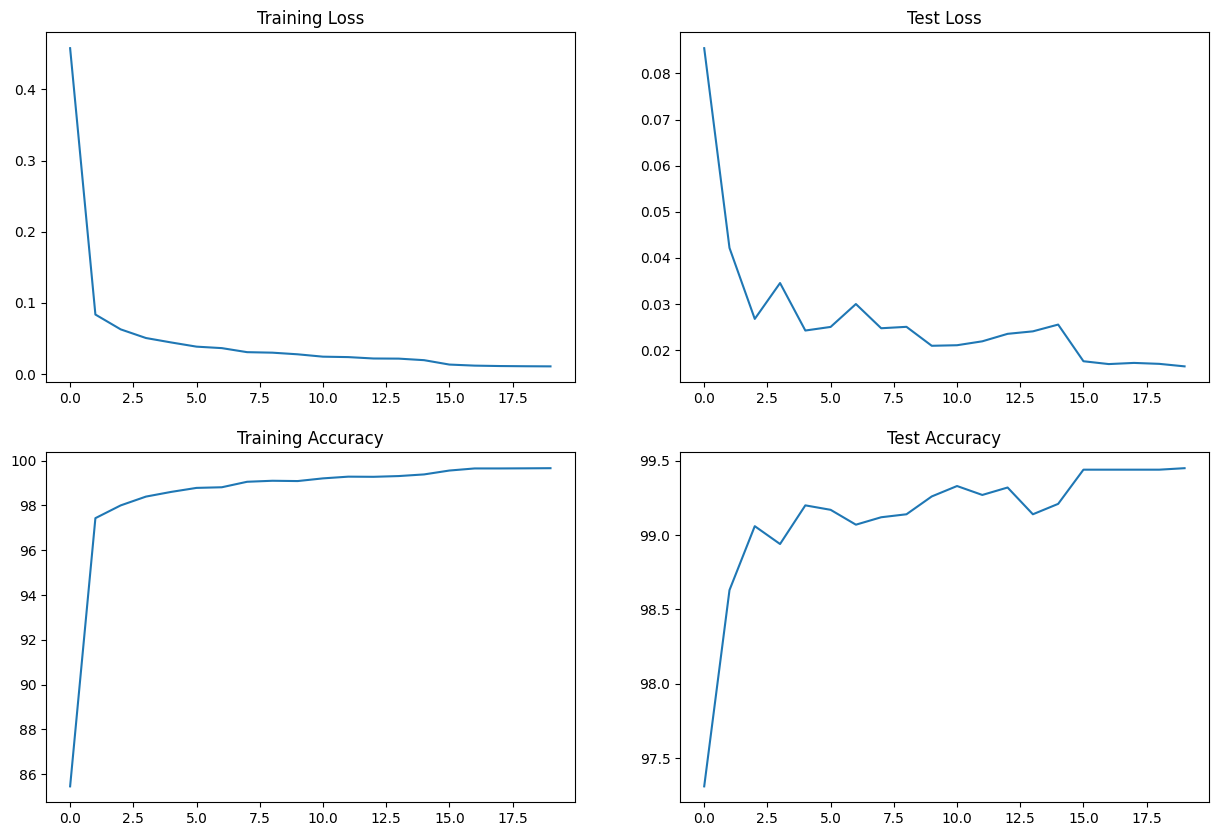

In [16]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")
plt.show()